In [1]:
# Importing necessary libraries for time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import seaborn as sns

In [3]:
# Read in the data
df = pd.read_csv('/Users/helenamabey/Stats_Spring_2025/Congestion Cleaned.csv')
df.head()

,Date,Month Year,Daily Vehicle Count,Regular Gas Price Average,Midgrade Gas Price Average,Premium Gas Price Average,Monthly_Max_Temp,Monthly_Min_Temp,Monthly_Sum_Precipitation,Monthly_Snowfall
0,2005-01-01,2005-01,19470,1.7660,1.8760,1.9800,32.3,12.7,2.29,36.0
1,2005-02-01,2005-02,21207,1.8550,1.9650,2.0650,33.9,10.5,2.14,37.5
2,2005-03-01,2005-03,22943,2.0825,2.1900,2.2875,39.5,17.5,1.49,20.0
3,2005-04-01,2005-04,21288,2.2300,2.3425,2.4450,49.9,24.0,2.24,20.0
4,2005-05-01,2005-05,23505,2.1540,2.2640,2.3640,62.1,30.5,1.01,2.0


In [5]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [7]:
# Select independent variables (Adding Regular Gas Price)
X_selected = df[['Monthly_Max_Temp', 'Regular Gas Price Average']]

# Add a constant for the intercept
X_selected = sm.add_constant(X_selected)

# Define the dependent variable
y = df['Daily Vehicle Count']

In [9]:
# 70/30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.30, random_state=42, shuffle=True)

# Log-transform the target variable
y_train_log = np.log(y_train)

# Fit the new model
model_sm_log = sm.OLS(y_train_log, X_train).fit()

# Print summary
print(model_sm_log.summary())

                             OLS Regression Results                            
Dep. Variable:     Daily Vehicle Count   R-squared:                       0.712
Model:                             OLS   Adj. R-squared:                  0.706
Method:                  Least Squares   F-statistic:                     122.1
Date:                 Fri, 07 Mar 2025   Prob (F-statistic):           1.89e-27
Time:                         20:03:29   Log-Likelihood:                 127.78
No. Observations:                  102   AIC:                            -249.6
Df Residuals:                       99   BIC:                            -241.7
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

In [13]:
# Predict on test data (log scale)
y_pred_log = model_sm_log.predict(X_test)

# Apply correction factor for log transformation bias
correction_factor = np.exp(model_sm_log.resid.var() / 2)
y_pred_original_scale = np.exp(y_pred_log) * correction_factor

# Compare actual vs predicted values
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_original_scale})
predictions_df.head()

,Actual,Predicted
Date,,
2008-10-01,23962,23853.264875
2013-02-01,19101,19654.576378
2007-04-01,22582,23419.099646
2006-08-01,27524,27006.864674
2008-07-01,28666,26780.278233


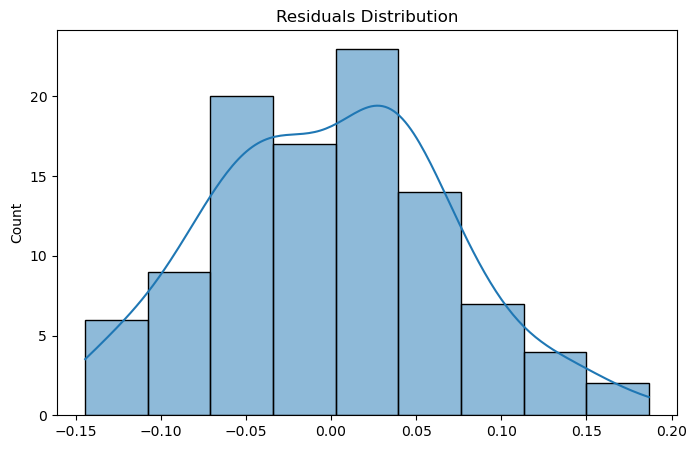

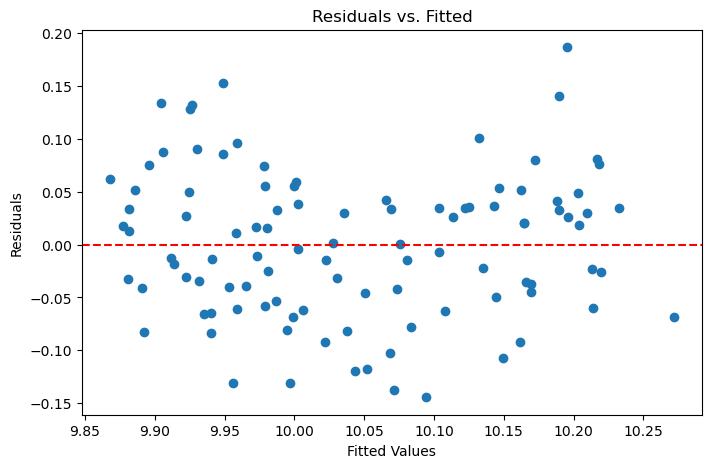

In [15]:
# Get residuals
residuals_log = model_sm_log.resid

# Histogram of residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals_log, kde=True)
plt.title("Residuals Distribution")
plt.show()

# Residuals vs. Fitted Values
plt.figure(figsize=(8,5))
plt.scatter(model_sm_log.fittedvalues, residuals_log)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()

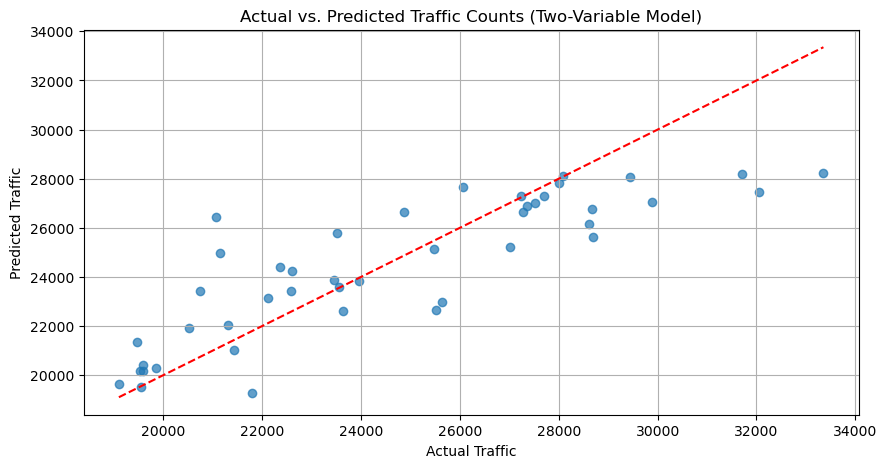

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_original_scale, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="dashed")  # 1:1 line
plt.xlabel("Actual Traffic")
plt.ylabel("Predicted Traffic")
plt.title("Actual vs. Predicted Traffic Counts (Two-Variable Model)")
plt.grid()
plt.show()

In [21]:
# Create future dates for March - December 2017
future_dates = pd.date_range(start="2017-03-01", end="2017-12-01", freq="MS")

# Estimate Monthly_Max_Temp and Regular Gas Price Average using historical means
monthly_avg_temp = df.groupby(df.index.month)['Monthly_Max_Temp'].mean()
monthly_avg_gas = df.groupby(df.index.month)['Regular Gas Price Average'].mean()

# Assign estimated values based on historical averages
future_temps = [monthly_avg_temp[date.month] for date in future_dates]
future_gas_prices = [monthly_avg_gas[date.month] for date in future_dates]

# Create future DataFrame
future_df = pd.DataFrame({
    'Monthly_Max_Temp': future_temps,
    'Regular Gas Price Average': future_gas_prices
}, index=future_dates)

# Add constant for regression model
future_df = sm.add_constant(future_df)

future_df.head()  # Check future data


,const,Monthly_Max_Temp,Regular Gas Price Average
2017-03-01,1.0,41.833333,2.724792
2017-04-01,1.0,49.208333,2.880000
2017-05-01,1.0,59.350000,3.014167
2017-06-01,1.0,72.100000,3.050000
2017-07-01,1.0,76.766667,3.038458


In [23]:
# Predict on future data (March - December 2017)
future_pred_log = model_sm_log.predict(future_df)

# Convert back to original scale
future_pred_original_scale = np.exp(future_pred_log) * correction_factor

# Store predictions
future_predictions_df = pd.DataFrame({'Predicted_Vehicle_Count': future_pred_original_scale}, index=future_dates)

future_predictions_df

,Predicted_Vehicle_Count
2017-03-01,21942.236112
2017-04-01,22945.071702
2017-05-01,24475.123562
2017-06-01,26682.499022
2017-07-01,27565.842751
2017-08-01,26953.912706
2017-09-01,25736.434203
2017-10-01,23764.819566
2017-11-01,21651.298980
2017-12-01,20153.574913


In [35]:
# Extract 2016 actual traffic (Jan-Dec)
traffic_2016 = df.loc["2016", "Daily Vehicle Count"]

# Extract ONLY January & February 2017 actual traffic counts
traffic_2017_actual = df.loc["2017-01":"2017-02", "Daily Vehicle Count"]

# Extract 2017 predicted traffic (Mar-Dec only)
traffic_2017_predicted = future_predictions_df['Predicted_Vehicle_Count']

# Create a full index for Jan-Dec 2017
full_2017_index = pd.date_range(start="2017-01-01", periods=12, freq="MS")

In [37]:
# Create an empty DataFrame with the full 2017 index
comparison_df = pd.DataFrame(index=full_2017_index)

# Assign 2016 actual traffic (aligned with Jan-Dec)
comparison_df['2016 Traffic'] = traffic_2016.values

# Assign 2017 actual traffic (only for Jan-Feb)
comparison_df.loc["2017-01-01":"2017-02-01", '2017 Actual'] = traffic_2017_actual.values

# Assign 2017 predicted traffic (only for Mar-Dec)
comparison_df.loc["2017-03-01":"2017-12-01", '2017 Predicted'] = traffic_2017_predicted.values

comparison_df

,2016 Traffic,2017 Actual,2017 Predicted
2017-01-01,22470,21883.0,NaN
2017-02-01,20829,23391.0,NaN
2017-03-01,25512,NaN,21942.236112
2017-04-01,23563,NaN,22945.071702
2017-05-01,27800,NaN,24475.123562
2017-06-01,31702,NaN,26682.499022
2017-07-01,33354,NaN,27565.842751
2017-08-01,32044,NaN,26953.912706
2017-09-01,30647,NaN,25736.434203
2017-10-01,27020,NaN,23764.819566


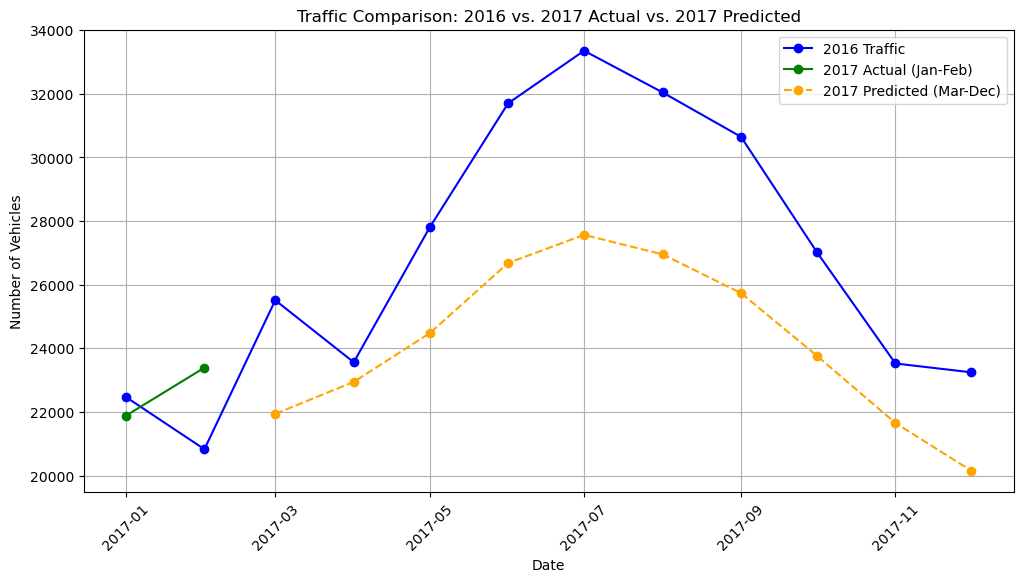

In [39]:
plt.figure(figsize=(12, 6))

# Plot actual 2016 traffic
plt.plot(comparison_df.index, comparison_df['2016 Traffic'], label="2016 Traffic", marker="o", linestyle="-", color="blue")

# Plot actual 2017 traffic (Jan-Feb)
plt.plot(comparison_df.index[:2], comparison_df['2017 Actual'].dropna(), label="2017 Actual (Jan-Feb)", marker="o", linestyle="-", color="green")

# Plot predicted 2017 traffic (Mar-Dec)
plt.plot(comparison_df.index[2:], comparison_df['2017 Predicted'].dropna(), label="2017 Predicted (Mar-Dec)", marker="o", linestyle="dashed", color="orange")

plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.title("Traffic Comparison: 2016 vs. 2017 Actual vs. 2017 Predicted")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()